## For Publication on GitHub:

# Bright Horizons Family Solutions (NYSE: BFAM) Analysis
### Applying Data Science Tools to Validate, in Real-time, a Bearish Investment Thesis on BFAM

    Josh Grasso | joshgrasso@gmail.com

The aim of this project is to provide real-time insights into the post-COVID re-opening of Bright Horizons' network of daycare centers by leveraging the Google Maps API. These insights include two main parameters: the number of locations that have been <u>"permanently closed"</u> - informing forecasts of BFAM's revenue eventually returning to pre-COVID levels - and the number of locations that are "operational" as compared to <u>"temporarily closed"</u> - informing near-term (prior, current, and +1 quarter) financial forecasts. These insights lower risk/uncertainty regarding the current status of BFAM's daycare business, regardless of opinion of the future trajectory of a re-opening.   


### Code Instructions: 
* First, I removed the Google Maps requests from this notebook inorder to make it overall more accessible to a wider audience. The Google Maps requests requires a individual Google Cloud API key with which to validate any request. Thus, including this functionality would require readers to input their own individual API key, and possibly register for an API key if this was their first Google API call. Overall, not much is lost and much is gained - as I will be running the requests and pushing the updated results (CSV's) up to GitHub to keep the data as fresh as possible. 

* Second, I recommend running all the code at once, reading the intro, and then jumping down and reading the conclusion. In order to do that: click "Cell" in the navigation bar above, then select "Run All." The code should execute very quickly, since the Google Maps requests have been removed. 


### Brief Description of BFAM: 
As of the beggining of this year, BFAM operates a global total of \~1,100 daycare centers, \~65% are in the U.S. (710 locations), \~30% are in the U.K. (313 locations), and \~5% are in the Netherlands (61 locations). I have been able to access \~440 locations in the U.S. that are listed on the BFAM's website (link below) through a web-scrape, as well as an additional 165 locations in the U.S. identified from a broader Google Maps search. Combined, this represents \~85% of BFAM's total U.S. location count. I have also been able to access information on 57 locations in the U.K. representing \~18% of BFAM's U.K. location count. Overall, the dataset provides hard evidence on \~47% of BFAM's global day-care centers, a business-segment which represents over 80% of BFAM's total company revenue. Overall, insights can be inferred to all of BFAM's center-based reveune by extrapolating the sample population data in the U.K.(from the 14 largest metro-areas), and assuming that all of the Netherlands locations are open (which has been press released by BFAM).  

#### For Context: A Brief Summary of 2020 Newsflow: 
* Pre-COVID, the growth outlook for Bright Horizons was for 6%-10% top-line growth as well as 50-100 bps of annual margin expansion per management’s guidance. Components of top-line growth include 1-2% from enrollment growth, 1-2% from new center openings, 3-4% from tuition growth (ASP increases), 1-2% from back-up care and ed advisory (the other ~20% of revenue) and 1-2% from M&A, with (1-2%) from closure of underperforming branches. Directly following Q4'19 earnings reporting, BFAM traded at a ~42x forward P/E ratio per Goldman Sachs' analyst estimates, with a forward price target based on a 39.5x 2-yr forward P/E estimate. The target price multiple represented 2.1x the S&P 500’s forward P/E vs. BFAM’s 5-year average SPX-relative earnings multiple of 1.8x.
* On <u>March 11th 2020</u>, BFAM's CEO stated that “they have not seen any financial impact or disruptions to date.”
* In an 8-K published <u>March 18th, 2020</u>, BFAM stated that "Bright Horizons will temporarily close more than half of its U.S.-based centers...until the end of April" and "we operate approximately 300 centers in the U.K., and currently those centers remain open."  
* In an 8-K published <u>March 24th, 2020</u>, BFAM stated that "We are currently operating approximately 150 child care centers in the U.S." with only "approximately 30 client and “hub” nurseries in the U.K. to remain open." 
* With Q1'20 results on <u>May 6th 2020</u>, BFAM released that ~150 centers in the U.S. were operational, ~35 centers in the U.K., and 60 centers in the Netherlands.  
* In an 8-K published <u>June 8th 2020</u>, BFAM stated that it "expects to reopen between 150 and 175 centers by June 30, 2020" and "expect to continue the phased reopening through the third quarter."
* On <u>June 11th 2020</u>, Goldman Sachs' analyst <u>lowered</u> their 2020 EPS estimate \~30% to 2.73 from 3.73 for 2020, but still <u>raised</u> their target price by using a higher, 56.0x forward P/E multiple, equating to nearly 3x the forward P/E multiple on the S&P 500 at the time.


### Conclusion:  
See Conclusion section below for a summary of the data and rendering of key charts. 

#### Key Resources:
* https://googlemaps.github.io/google-maps-services-python/docs/index.html#googlemaps.Client.find_place
* https://www.brighthorizons.com/child-care-locator/locations

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from pathlib import Path
#import googlemaps
import os
import openpyxl
import pprint

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')

import requests, bs4

today = datetime.now()
month,day,year = today.month,today.day,today.year
csv_folder = Path.home() / 'Jupyter' / 'BFAM_Project' / 'BFAM_Google_Maps_Analysis' / 'CSVs'

## BFAM Website Scrape: Location Information Published on BFAM's Website
The following code pulls and keeps track of the daycare center locations published on Bright Horizon's website. This was used for the initial download of location data from Google Maps. I also use it to keep track of how many locations may be permanently closing, by keeping track of the locations that are taken down from the website. This data not only corroborates the Google Map data showing a change in "business status" to "permanently closed," but has been shown to lead any changes to Google Maps by at least a few days 

Note that the BFAM website lists only ~440 locations out of a total of ~710 U.S. locations. I suspect (but would need to confirm) that the locations that are listed on the website are largely leased locations, and not employer-sponsored locations. A broader Google Maps search in the next section was able to identify an additional 165 BFAM locations.

In [2]:
# Beautiful Soup: 
res = requests.get('https://www.brighthorizons.com/child-care-locator/locations')
res.raise_for_status() 
bfam_soup = bs4.BeautifulSoup(res.text, 'html.parser')
elms = bfam_soup.select('div span')

# Search HTML for Location Names:  <span class="location-name">
location_name = bfam_soup.find_all(lambda tag: tag.name == 'span' and 
                                   tag.get('class') == ['location-name'])
# Search HTML for Location Addresses:  <span class="location-address">
location_address = bfam_soup.find_all(lambda tag: tag.name == 'span' and 
                                   tag.get('class') == ['location-address'])
# Search HTML for Location Zip & State <span class="location-zip-state"
location_zip_state = bfam_soup.find_all(lambda tag: tag.name == 'span' and 
                                   tag.get('class') == ['location-zip-state'])

print("There are {}* names & websites, {} addresses, and {} Zip & States".format(
    len(location_name), len(location_address), len(location_zip_state)))
print('* note that the website lists several corp. offices (named & unnamed)')

There are 419* names & websites, 423 addresses, and 423 Zip & States
* note that the website lists several corp. offices (named & unnamed)


In [3]:
# Parse Names: Used for the Google Maps Search
# TO DO: Is there are read JSON way to do this that's easier? 
bfam_names = []
bfam_websites = []
for i in range(len(location_name)):
    _ = str(location_name[i]).replace('<span class="location-name"><a class="txt-nileblue" href="','').replace(
        '</a></span>','')
    _website,_name = _.split('" target="_blank">')
    bfam_names.append(_name)
    bfam_websites.append(_website)

# Parse Location Address ( incl. Zip & State):
bfam_addresses = []
for i in range(len(location_address)):
    _address = str(location_address[i]).replace('<span class="location-address">','').replace('</span>','').strip()
    _zip = str(location_zip_state[i]).replace('<span class="location-zip-state">','').replace('</span>','').strip()
    bfam_addresses.append(','.join([_address,_zip]))
#print("First Entry: {}\n{}\n{}".format(bfam_names[0],bfam_websites[0],bfam_addresses[0]))

# Convert BFAM Website Data to DataFrame and Store in CSV form in File
# Note: Names & Addresses & Websites line up until West Virginia, which is the last location (was #443, line #442)
# The remaining entries are corporate headquarters, across several countries
new_bfam_website_locations = pd.DataFrame.from_dict({'Names': bfam_names, 'Addresses': bfam_addresses, 
                                                 'Websites': bfam_websites},orient='index').transpose()
new_bfam_website_locations[-10:]

,Names,Addresses,Websites
413,Bright Horizons at the Y,"8501 Campus Drive,Mount Pleasant, WI 53406",https://www.brighthorizons.com/sealedair
414,Bright Horizons at Watertown Plank,"8624 W. Watertown Plank Road,Milwaukee, WI 53226",https://www.brighthorizons.com/watertownplank
415,Bright Horizons Family Solutions,"200 Talcott Avenue, South,Watertown, MA 02472",https://www.google.com/maps/search/?api=1&amp;...
416,Bright Horizons Family Solutions,"1011 Warrenville Road, Suite 160,Lisle, IL 60532",https://www.google.com/maps/search/?api=1&amp;...
417,Bright Horizons Family Solutions,"2655 W. Midway Blvd, Suite 330,Broomfield, CO ...",https://www.google.com/maps/search/?api=1&amp;...
418,Kindergarden Nederland B.V.,"2 Crown Court,Rushden Northamptonshire NN10 6BS",https://www.google.com/maps/search/?api=1&amp;...
419,None,"305 Great Portland Street,West Central London ...",None
420,None,"26 Whitehouse Road,Edinburgh EH4 6PH",None
421,None,"Summerfield’s Village Centre, Dean Row Road,Wi...",None
422,None,"Herengracht 244,Amsterdam 1016 BT",None


In [4]:
# REMOVE Corporate Offices: 
# Load Corporate Offices CSV
BFAM_remove_corp_offices_path = csv_folder / Path('BFAM_remove_corp_offices.csv')
bfam_remove_corp_offices = pd.read_csv(BFAM_remove_corp_offices_path)

_match_remove_remove_corp_offices = pd.merge(new_bfam_website_locations,bfam_remove_corp_offices,how='inner',
                                             left_on=['Names','Addresses'],right_on=['Names','Addresses'])
new_bfam_website_locations = new_bfam_website_locations.set_index('Addresses').drop(index=_match_remove_remove_corp_offices['Addresses']).reset_index()
new_bfam_website_locations.tail()

,Addresses,Names,Websites
410,"419 Wakara Way Suite 100,Salt Lake City, UT 84108",Bright Horizons at U of U Research Park,https://www.brighthorizons.com/uhcdc
411,"2240 Golf Road,Pewaukee, WI 53072",Bright Horizons at Pewaukee,https://www.brighthorizons.com/pewaukee
412,"5119 American Family Drive,Madison, WI 53718",Bright Horizons at the American Center,https://www.brighthorizons.com/american
413,"8501 Campus Drive,Mount Pleasant, WI 53406",Bright Horizons at the Y,https://www.brighthorizons.com/sealedair
414,"8624 W. Watertown Plank Road,Milwaukee, WI 53226",Bright Horizons at Watertown Plank,https://www.brighthorizons.com/watertownplank


In [5]:
# Load Prior Data:
BFAM_website_locations_path = csv_folder / Path('BFAM_website_locations.csv')
prior_bfam_website_locations = pd.read_csv(BFAM_website_locations_path)
prior_bfam_website_locations.set_index(['Names','Addresses'],inplace=True)

In [6]:
bfam_website_locations = prior_bfam_website_locations

In [7]:
# What locations have fallen off the website? 
date_last_entry = list(bfam_website_locations.columns)
dropped_from_bfam_website = bfam_website_locations[bfam_website_locations[date_last_entry[-1]] != True]
dropped_from_bfam_website

,,Websites,6.4.2020,6.5.2020,6.8.2020,6.9.2020,6.10.2020,6.12.2020,6.13.2020,6.15.2020,6.16.2020,...,7.6.2020,7.7.2020,7.8.2020,7.13.2020,7.15.2020,7.17.2020,7.20.2020,7.22.2020,7.24.2020,7.27.2020
Names,Addresses,,,,,,,,,,,,,,,,,,,,,
Bright Horizons @ Building Blocks,"520 15th Street SW,Auburn, WA 98001",https://www.brighthorizons.com/auburn,True,True,True,True,True,True,True,True,True,...,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Bright Horizons At Centennial Mall,"100 Centennial Mall North, Suite 140,Lincoln, NE 68508",https://www.brighthorizons.com/centennialmall,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,NaN,NaN,NaN
Bright Horizons Early Learning Center of Sioux Falls,"4800 North 4th Avenue,Sioux Falls, SD 57104",https://www.brighthorizons.com/cscfamilysd,True,True,True,True,True,True,True,True,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Bright Horizons at Bee Cave,"14058 Bee Cave Parkway,Bee Cave, TX 78738",https://www.brighthorizons.com/beecave,True,True,True,True,True,True,True,True,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Bright Horizons at Bright Beginnings Learning Center,"1900 23rd Street S,Great Falls, MT 59405",https://www.brighthorizons.com/greatfallscolle...,True,True,True,True,True,True,True,True,True,...,True,True,True,True,NaN,NaN,NaN,NaN,NaN,NaN
Bright Horizons at Cranbury,"2557 Route 130 South,Cranbury, NJ 08512",https://www.brighthorizons.com/cranbury,True,True,True,True,True,True,True,True,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Bright Horizons at East Brunswick,"635 Cranbury Road,East Brunswick, NJ 08816",https://www.brighthorizons.com/eastbrunswick,True,True,True,True,True,True,True,True,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Bright Horizons at Henrico,"120 Towne Center West Boulevard,Richmond, VA 23233",https://www.brighthorizons.com/henrico,True,True,True,True,True,True,True,True,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Bright Horizons at Kendall Park,"10 Gateway Boulevard,Kendall Park, NJ 08824",https://www.brighthorizons.com/kendallpark,True,True,True,True,True,True,True,True,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
# Permanantly Closed Locations: 
_dropped = dropped_from_bfam_website.drop(columns='Websites').droplevel('Addresses',axis=0)
_dropped = _dropped.T*0
final_dropped = _dropped.fillna(1)
final_dropped.index = pd.to_datetime(final_dropped.index)
final_dropped.index = final_dropped.index.to_period("B")

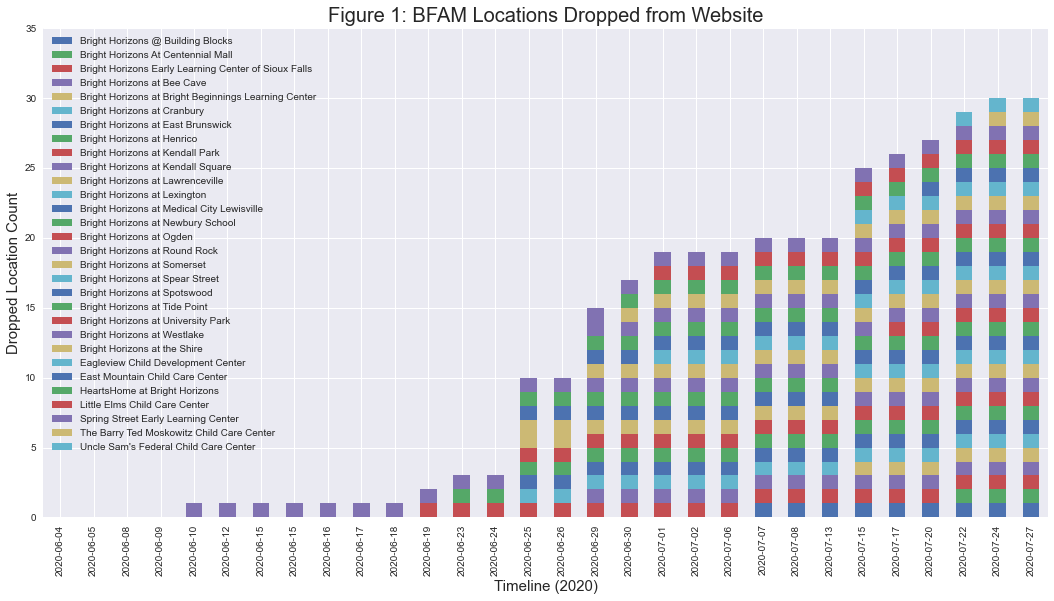

In [9]:
# CHART: BFAM Locations Dropped from Website
y_max_fig_1 = (round(final_dropped.index.size/5)+1)*5 # Y-Lim

final_dropped.plot(kind='bar', stacked=True, figsize=(18,9), ylim=[0, y_max_fig_1])
plt.title("Figure 1: BFAM Locations Dropped from Website",fontsize=20) 
plt.ylabel("Dropped Location Count",fontsize=15)
plt.xlabel("Timeline (2020)",fontsize=15)
plt.legend(fontsize=10,loc="upper left");

## Google Maps API: Search Google Maps for Bright Horizons Family Locations
This code performs a search for the business status of the ~440 locations listed on the BFAM website.

In [10]:
# Load Prior Data
BFAM_status_timeline_path = csv_folder / Path('BFAM_status_timeline.csv')
prior_bfam_status_timeline = pd.read_csv(BFAM_status_timeline_path,index_col=0)

In [11]:
"""
# Call My Google API Key:
# Google Maps:
gmaps = googlemaps.Client(key= my_gmaps_key)
# Search Google Maps for the BFAM locations: Listed on the BFAM website
_search_dict = {}
for place_id,name in prior_bfam_status_timeline['name'].iteritems():
    _search_dict[place_id] = gmaps.place(place_id,fields=['business_status'])['result']['business_status']

# Append the latest Google Maps Search to Timeline
date_new_entry = "{}.{}.{}".format(month,day,year)
_new_data_frame = pd.DataFrame.from_dict(_search_dict,orient='index',columns=[date_new_entry])
bfam_status_timeline = prior_bfam_status_timeline.join(_new_data_frame,how='outer') #on='place_id'
"""

'\n# Call My Google API Key:\n# Google Maps:\ngmaps = googlemaps.Client(key= my_gmaps_key)\n# Search Google Maps for the BFAM locations: Listed on the BFAM website\n_search_dict = {}\nfor place_id,name in prior_bfam_status_timeline[\'name\'].iteritems():\n    _search_dict[place_id] = gmaps.place(place_id,fields=[\'business_status\'])[\'result\'][\'business_status\']\n\n# Append the latest Google Maps Search to Timeline\ndate_new_entry = "{}.{}.{}".format(month,day,year)\n_new_data_frame = pd.DataFrame.from_dict(_search_dict,orient=\'index\',columns=[date_new_entry])\nbfam_status_timeline = prior_bfam_status_timeline.join(_new_data_frame,how=\'outer\') #on=\'place_id\'\n'

In [12]:
# Check and Remove any ID's on the Remove list
clean_bfam_status_timeline = prior_bfam_status_timeline
#clean_bfam_status_timeline.head(1)

In [13]:
# Summary Statistics Table: BFAM Website Locations
website_dates_list = list(clean_bfam_status_timeline.columns)
_initialize_counts = clean_bfam_status_timeline[website_dates_list[1]].value_counts()
bfam_timeline_counts = _initialize_counts.to_frame(name=clean_bfam_status_timeline[website_dates_list[1]].name)
for i in range(2,len(website_dates_list)):
    bfam_timeline_counts = bfam_timeline_counts.join(clean_bfam_status_timeline[website_dates_list[i]].value_counts(),
                                                     how='outer')

In [14]:
# Add Total and % of Total Columns
bfam_timeline_counts.fillna(value=0,inplace=True)
bfam_timeline_counts = bfam_timeline_counts.T

bfam_timeline_counts['Total_Locations'] = bfam_timeline_counts.sum(axis=1)
bfam_timeline_counts['%_Operational'] = bfam_timeline_counts['OPERATIONAL'] / bfam_timeline_counts['Total_Locations']
bfam_timeline_counts['%_Temp_Closed'] = bfam_timeline_counts['CLOSED_TEMPORARILY'] / bfam_timeline_counts['Total_Locations']
bfam_timeline_counts['%_Perm_Closed'] = bfam_timeline_counts['CLOSED_PERMANENTLY'] / bfam_timeline_counts['Total_Locations']

bfam_timeline_counts.astype({'OPERATIONAL':'int32','CLOSED_TEMPORARILY':'int64','CLOSED_PERMANENTLY':'int64',
                            'Total_Locations':'int64'},copy=False)

bfam_timeline_counts.index.name = 'Dates'
bfam_timeline_counts.index = pd.to_datetime(bfam_timeline_counts.index)
bfam_timeline_counts.tail()

,CLOSED_PERMANENTLY,CLOSED_TEMPORARILY,OPERATIONAL,Total_Locations,%_Operational,%_Temp_Closed,%_Perm_Closed
Dates,,,,,,,
2020-07-17,5.0,239.0,197.0,441.0,0.446712,0.541950,0.011338
2020-07-20,5.0,239.0,197.0,441.0,0.446712,0.541950,0.011338
2020-07-22,6.0,189.0,246.0,441.0,0.557823,0.428571,0.013605
2020-07-24,8.0,183.0,250.0,441.0,0.566893,0.414966,0.018141
2020-07-27,9.0,183.0,249.0,441.0,0.564626,0.414966,0.020408


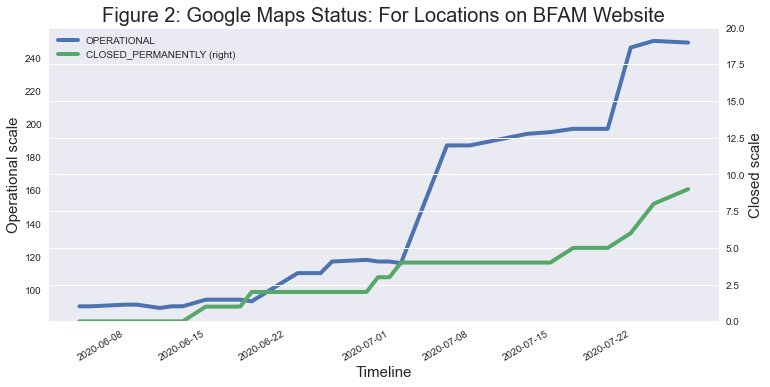

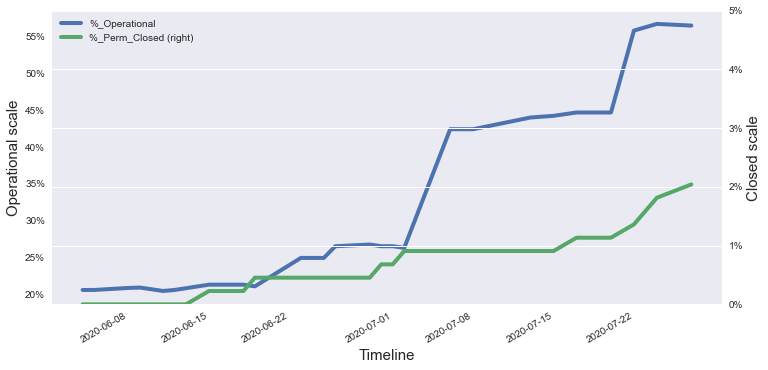

In [15]:
# CHART: Google Maps Status: For Locations on BFAM Website 
ax_1 = bfam_timeline_counts[['OPERATIONAL','CLOSED_PERMANENTLY']].plot(
    secondary_y='CLOSED_PERMANENTLY',figsize=(12,6),linewidth=4);
ax_1.set_ylabel('Operational scale',fontsize=15)
ax_1.set_xlabel('Timeline',fontsize=15)
ax_1.right_ax.set_ylabel('Closed scale',fontsize=15)
ax_1.right_ax.set_ylim(0,20);

plt.title("Figure 2: Google Maps Status: For Locations on BFAM Website",fontsize=20) 

ax_2 = bfam_timeline_counts[['%_Operational','%_Perm_Closed']].plot(
    secondary_y='%_Perm_Closed',figsize=(12,6),linewidth=4);
ax_2.set_ylabel('Operational scale',fontsize=15)
ax_2.set_xlabel('Timeline',fontsize=15)
ax_2.right_ax.set_ylabel('Closed scale',fontsize=15)
ax_2.right_ax.set_ylim(0,0.05);
vals_l = ax_2.get_yticks();
ax_2.set_yticklabels(['{:,.0%}'.format(y) for y in vals_l])
vals_r = ax_2.right_ax.get_yticks()
ax_2.right_ax.set_yticklabels(['{:,.0%}'.format(y) for y in vals_r]);

In [16]:
#Permanently Closed: Data & Charting
date_last_entry = list(clean_bfam_status_timeline.columns)
clean_bfam_status_timeline[clean_bfam_status_timeline[date_last_entry[-1]] == 'CLOSED_PERMANENTLY']

,name,6.4.2020,6.5.2020,6.8.2020,6.9.2020,6.10.2020,6.11.2020,6.12.2020,6.13.2020,6.15.2020,...,7.6.2020,7.7.2020,7.8.2020,7.13.2020,7.15.2020,7.17.2020,7.20.2020,7.22.2020,7.24.2020,7.27.2020
place_id,,,,,,,,,,,,,,,,,,,,,
ChIJ-1S9YslqkFQRC-BCdFh0FsU,Spring Street Early Learning Center,OPERATIONAL,OPERATIONAL,OPERATIONAL,OPERATIONAL,NaN,NaN,NaN,NaN,CLOSED_PERMANENTLY,...,CLOSED_PERMANENTLY,CLOSED_PERMANENTLY,CLOSED_PERMANENTLY,CLOSED_PERMANENTLY,CLOSED_PERMANENTLY,CLOSED_PERMANENTLY,CLOSED_PERMANENTLY,CLOSED_PERMANENTLY,CLOSED_PERMANENTLY,CLOSED_PERMANENTLY
ChIJCV9XO_u-locRjxcHfmXEw5g,Bright Horizons At Centennial Mall,CLOSED_TEMPORARILY,CLOSED_TEMPORARILY,CLOSED_TEMPORARILY,CLOSED_TEMPORARILY,CLOSED_TEMPORARILY,CLOSED_TEMPORARILY,CLOSED_TEMPORARILY,CLOSED_TEMPORARILY,CLOSED_TEMPORARILY,...,CLOSED_TEMPORARILY,CLOSED_TEMPORARILY,CLOSED_TEMPORARILY,CLOSED_TEMPORARILY,CLOSED_TEMPORARILY,CLOSED_TEMPORARILY,CLOSED_TEMPORARILY,CLOSED_PERMANENTLY,CLOSED_PERMANENTLY,CLOSED_PERMANENTLY
ChIJMwuv5ctKiYcRdUQDCZ-GbmQ,Bright Horizons Early Learning Center of Sioux...,OPERATIONAL,OPERATIONAL,OPERATIONAL,OPERATIONAL,OPERATIONAL,OPERATIONAL,OPERATIONAL,OPERATIONAL,OPERATIONAL,...,CLOSED_PERMANENTLY,CLOSED_PERMANENTLY,CLOSED_PERMANENTLY,CLOSED_PERMANENTLY,CLOSED_PERMANENTLY,CLOSED_PERMANENTLY,CLOSED_PERMANENTLY,CLOSED_PERMANENTLY,CLOSED_PERMANENTLY,CLOSED_PERMANENTLY
ChIJV05Q1yM4W4YRnrQpXBsgdWM,Bright Horizons at Bee Cave,OPERATIONAL,OPERATIONAL,OPERATIONAL,OPERATIONAL,OPERATIONAL,OPERATIONAL,OPERATIONAL,OPERATIONAL,OPERATIONAL,...,CLOSED_PERMANENTLY,CLOSED_PERMANENTLY,CLOSED_PERMANENTLY,CLOSED_PERMANENTLY,CLOSED_PERMANENTLY,CLOSED_PERMANENTLY,CLOSED_PERMANENTLY,CLOSED_PERMANENTLY,CLOSED_PERMANENTLY,CLOSED_PERMANENTLY
ChIJWZ1XY3kOU4cRiw4DSVlS5QU,Bright Horizons at Ogden,CLOSED_TEMPORARILY,CLOSED_TEMPORARILY,CLOSED_TEMPORARILY,CLOSED_TEMPORARILY,CLOSED_TEMPORARILY,CLOSED_TEMPORARILY,CLOSED_TEMPORARILY,CLOSED_TEMPORARILY,CLOSED_TEMPORARILY,...,CLOSED_TEMPORARILY,CLOSED_TEMPORARILY,CLOSED_TEMPORARILY,CLOSED_TEMPORARILY,CLOSED_TEMPORARILY,CLOSED_PERMANENTLY,CLOSED_PERMANENTLY,CLOSED_PERMANENTLY,CLOSED_PERMANENTLY,CLOSED_PERMANENTLY
ChIJc3f_fEgZTIYRC8vCgHncpvU,Bright Horizons at the Shire,CLOSED_TEMPORARILY,CLOSED_TEMPORARILY,CLOSED_TEMPORARILY,CLOSED_TEMPORARILY,CLOSED_TEMPORARILY,CLOSED_TEMPORARILY,CLOSED_TEMPORARILY,CLOSED_TEMPORARILY,CLOSED_TEMPORARILY,...,CLOSED_TEMPORARILY,CLOSED_TEMPORARILY,CLOSED_TEMPORARILY,CLOSED_TEMPORARILY,CLOSED_TEMPORARILY,CLOSED_TEMPORARILY,CLOSED_TEMPORARILY,CLOSED_TEMPORARILY,CLOSED_PERMANENTLY,CLOSED_PERMANENTLY
ChIJlZWC-gsuTIYRmdx04LM9vbc,Bright Horizons at Medical City Lewisville,OPERATIONAL,OPERATIONAL,OPERATIONAL,OPERATIONAL,OPERATIONAL,OPERATIONAL,OPERATIONAL,OPERATIONAL,OPERATIONAL,...,CLOSED_PERMANENTLY,CLOSED_PERMANENTLY,CLOSED_PERMANENTLY,CLOSED_PERMANENTLY,CLOSED_PERMANENTLY,CLOSED_PERMANENTLY,CLOSED_PERMANENTLY,CLOSED_PERMANENTLY,CLOSED_PERMANENTLY,CLOSED_PERMANENTLY
ChIJo1TpHjnSRIYRi49oR_QUPME,Bright Horizons at Round Rock,CLOSED_TEMPORARILY,CLOSED_TEMPORARILY,CLOSED_TEMPORARILY,CLOSED_TEMPORARILY,CLOSED_TEMPORARILY,CLOSED_TEMPORARILY,CLOSED_TEMPORARILY,CLOSED_TEMPORARILY,CLOSED_TEMPORARILY,...,CLOSED_TEMPORARILY,CLOSED_TEMPORARILY,CLOSED_TEMPORARILY,CLOSED_TEMPORARILY,CLOSED_TEMPORARILY,CLOSED_TEMPORARILY,CLOSED_TEMPORARILY,CLOSED_TEMPORARILY,OPERATIONAL,CLOSED_PERMANENTLY
ChIJtWMluqTCw4kRmAVRF0-ycZw,Bright Horizons at Kendall Park,CLOSED_TEMPORARILY,CLOSED_TEMPORARILY,CLOSED_TEMPORARILY,CLOSED_TEMPORARILY,CLOSED_TEMPORARILY,CLOSED_TEMPORARILY,CLOSED_TEMPORARILY,CLOSED_TEMPORARILY,CLOSED_TEMPORARILY,...,CLOSED_TEMPORARILY,CLOSED_TEMPORARILY,CLOSED_TEMPORARILY,CLOSED_TEMPORARILY,CLOSED_TEMPORARILY,CLOSED_TEMPORARILY,CLOSED_TEMPORARILY,CLOSED_TEMPORARILY,CLOSED_PERMANENTLY,CLOSED_PERMANENTLY


## Broader Google Maps Search: (Additional Locations Not Listed on Website)
Through a broader Google Maps search for "Bright Horizon Family," across the largest 317 U.S. cities (using geocodes from Wikipedia), I screened and identified an additional 165 BFAM locations not listed on the BFAM website. 

This code performs a search for the business status of these 165 locations.

In [17]:
# Load Prior Data
BFAM_broad_search_status_timeline_path = csv_folder / Path('BFAM_broad_search_status_timeline.csv')
prior_bfam_broad_search_status_timeline = pd.read_csv(BFAM_broad_search_status_timeline_path,index_col=0)
prior_bfam_broad_search_status_timeline.index.name = 'place_id'

# Load Original Search Results
BFAM_broad_search_results_path = csv_folder / Path('BFAM_broad_search_results.csv')
BFAM_broad_search_results_frame = pd.read_csv(BFAM_broad_search_results_path,index_col=0)

In [18]:
"""
# Search Google Maps for the BFAM locations not listed on the website:
_search_dict = {}
for place_id,name in prior_bfam_broad_search_status_timeline['name'].iteritems():
    _search_dict[place_id] = gmaps.place(place_id,fields=['business_status'])['result']['business_status']

# Append the latest Google Maps Search to Timeline
date_new_entry = "{}.{}.{}".format(month,day,year)
_new_data_frame = pd.DataFrame.from_dict(_search_dict,orient='index',columns=[date_new_entry])
bfam_broad_search_status_timeline = prior_bfam_broad_search_status_timeline.join(_new_data_frame,how='outer') #on='place_id'
bfam_broad_search_status_timeline.head(1)
"""

'\n# Search Google Maps for the BFAM locations not listed on the website:\n_search_dict = {}\nfor place_id,name in prior_bfam_broad_search_status_timeline[\'name\'].iteritems():\n    _search_dict[place_id] = gmaps.place(place_id,fields=[\'business_status\'])[\'result\'][\'business_status\']\n\n# Append the latest Google Maps Search to Timeline\ndate_new_entry = "{}.{}.{}".format(month,day,year)\n_new_data_frame = pd.DataFrame.from_dict(_search_dict,orient=\'index\',columns=[date_new_entry])\nbfam_broad_search_status_timeline = prior_bfam_broad_search_status_timeline.join(_new_data_frame,how=\'outer\') #on=\'place_id\'\nbfam_broad_search_status_timeline.head(1)\n'

In [19]:
# Append the latest Google Maps Search to Timeline
bfam_broad_search_status_timeline = prior_bfam_broad_search_status_timeline
#bfam_broad_search_status_timeline.head(1)

In [20]:
# Summary Statistics Table: Broader Search

broad_dates_list = list(bfam_broad_search_status_timeline.columns)
_initialize_counts = bfam_broad_search_status_timeline[broad_dates_list[1]].value_counts()
bfam_broad_search_timeline_counts = _initialize_counts.to_frame(name=bfam_broad_search_status_timeline[broad_dates_list[1]].name)
for i in range(2,len(broad_dates_list)):
    bfam_broad_search_timeline_counts = bfam_broad_search_timeline_counts.join(bfam_broad_search_status_timeline[broad_dates_list[i]].value_counts(),how='outer')

# Add Total and % of Total Columns
bfam_broad_search_timeline_counts = bfam_broad_search_timeline_counts.T
bfam_broad_search_timeline_counts['Total_Locations'] = bfam_broad_search_timeline_counts.sum(axis=1)
bfam_broad_search_timeline_counts['%_Operational'] = bfam_broad_search_timeline_counts['OPERATIONAL'] / bfam_broad_search_timeline_counts['Total_Locations']
bfam_broad_search_timeline_counts['%_Temp_Closed'] = bfam_broad_search_timeline_counts['CLOSED_TEMPORARILY'] / bfam_broad_search_timeline_counts['Total_Locations']
bfam_broad_search_timeline_counts['%_Perm_Closed'] = bfam_broad_search_timeline_counts['CLOSED_PERMANENTLY'] / bfam_broad_search_timeline_counts['Total_Locations']
bfam_broad_search_timeline_counts.astype({'OPERATIONAL':'int32','CLOSED_TEMPORARILY':'int64','CLOSED_PERMANENTLY':'int64',
                            'Total_Locations':'int64'},copy=False)

# Convert dates and index to datetime for more functionality:
bfam_broad_search_timeline_counts.index.name = 'Dates'
bfam_broad_search_timeline_counts.index = pd.to_datetime(bfam_broad_search_timeline_counts.index)
bfam_broad_search_timeline_counts.tail()

,OPERATIONAL,CLOSED_TEMPORARILY,CLOSED_PERMANENTLY,Total_Locations,%_Operational,%_Temp_Closed,%_Perm_Closed
Dates,,,,,,,
2020-07-17,128,32,5,165,0.775758,0.193939,0.030303
2020-07-20,128,32,5,165,0.775758,0.193939,0.030303
2020-07-22,132,28,5,165,0.800000,0.169697,0.030303
2020-07-24,132,28,5,165,0.800000,0.169697,0.030303
2020-07-27,132,28,5,165,0.800000,0.169697,0.030303


In [21]:
# Gather and format data for: BFAM Locations Closed Permanently (from Google Maps search)
date_last_entry = list(bfam_broad_search_status_timeline.columns)
_closed_perm_broad = bfam_broad_search_status_timeline[bfam_broad_search_status_timeline[date_last_entry[-1]] == 'CLOSED_PERMANENTLY']
#_closed_perm_broad

# Set values to 1 or 0 for bar chart
def closed_to_count(status):
    if status == 'CLOSED_PERMANENTLY':
        value = 1
    elif status == 'OPERATIONAL':
        value = 0
    else:
        value = status
    return value
closed_perm_broad = _closed_perm_broad.applymap(closed_to_count)

# Add Address to names to distinguish locations: (to do: clean this up a bit)
_address = closed_perm_broad['name'].to_frame().join(BFAM_broad_search_results_frame['formatted_address'],how='left') 
_address_list = _address['formatted_address'].apply(lambda x: x.split(", ")[::-1][:3]).to_frame()
_address_list[["Country","State","City"]] = pd.DataFrame(_address_list['formatted_address'].tolist(), 
                                                         index= _address_list.index)
_state = _address_list['State'].apply(lambda x: x.strip()[:2])
_address_list = _address_list.join(_state,rsuffix='_new')  #.drop('State',axis=1,inplace=True)
_address = _address.join(_address_list[['City','State_new']])
_address['New_Name'] = _address['name'].astype(str) + ' (' + _address['City'] + ', ' + _address['State_new'] + ')'

new_closed_perm_broad = closed_perm_broad.join(_address['New_Name']).drop('name',axis=1)

T_closed_perm_broad = new_closed_perm_broad.set_index('New_Name').T  #closed_perm_broad.set_index('name').T
T_closed_perm_broad.index = pd.to_datetime(T_closed_perm_broad.index)
T_closed_perm_broad.index = T_closed_perm_broad.index.to_period("B")


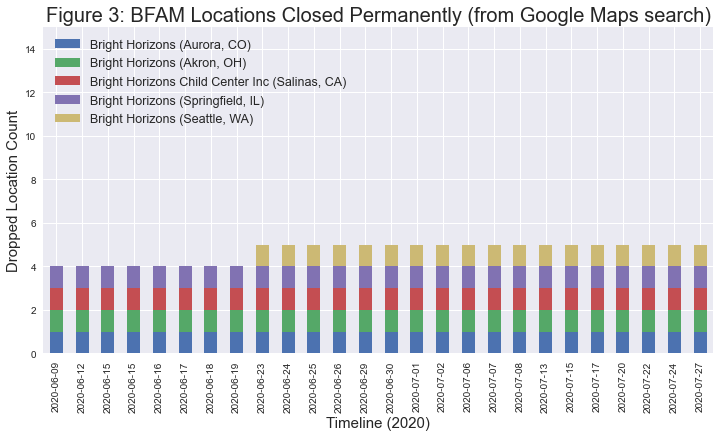

In [22]:
# CHART: BFAM Locations Closed Permanently (from Google Maps search)
T_closed_perm_broad.plot(kind='bar', stacked=True, figsize=(12,6), ylim=[0, 15]) 
plt.title("Figure 3: BFAM Locations Closed Permanently (from Google Maps search)",fontsize=20) 
plt.ylabel("Dropped Location Count",fontsize=15)
plt.xlabel("Timeline (2020)",fontsize=15)
plt.legend(fontsize=12.5,loc="upper left");

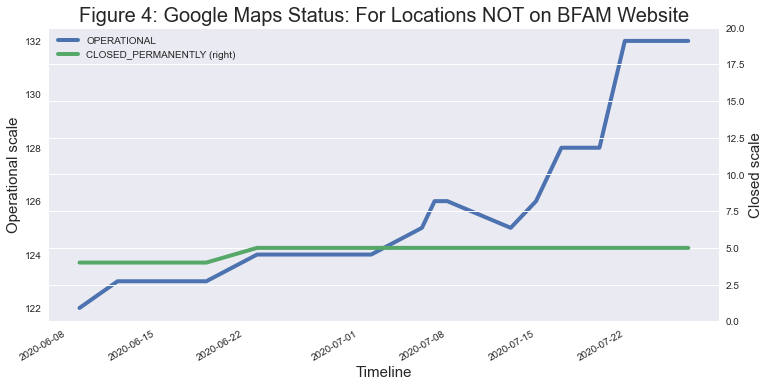

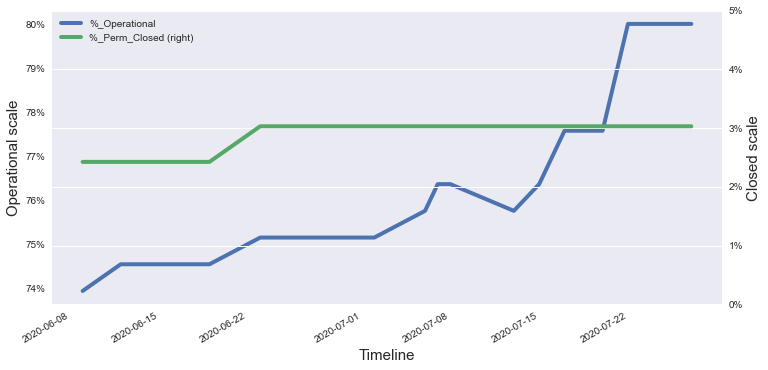

In [23]:
# CHART: Google Maps Status: For Locations NOT on BFAM Website 
ax_1 = bfam_broad_search_timeline_counts[['OPERATIONAL','CLOSED_PERMANENTLY']].plot(
    secondary_y='CLOSED_PERMANENTLY',figsize=(12,6),linewidth=4);
ax_1.set_ylabel('Operational scale',fontsize=15)
ax_1.set_xlabel('Timeline',fontsize=15)
ax_1.right_ax.set_ylabel('Closed scale',fontsize=15)
ax_1.right_ax.set_ylim(0,20)

plt.title("Figure 4: Google Maps Status: For Locations NOT on BFAM Website",fontsize=20)

ax_2 = bfam_broad_search_timeline_counts[['%_Operational','%_Perm_Closed']].plot(
    secondary_y='%_Perm_Closed',figsize=(12,6),linewidth=4);
ax_2.set_ylabel('Operational scale',fontsize=15)
ax_2.set_xlabel('Timeline',fontsize=15)
ax_2.right_ax.set_ylabel('Closed scale',fontsize=15)
ax_2.right_ax.set_ylim(0,0.05);
vals_l = ax_2.get_yticks();
ax_2.set_yticklabels(['{:,.0%}'.format(y) for y in vals_l])
vals_r = ax_2.right_ax.get_yticks()
ax_2.right_ax.set_yticklabels(['{:,.0%}'.format(y) for y in vals_r]);

## U.K. Google Maps Search:
Again, this search leverages a broader Google Maps search for "Bright Horizon Family," across the largest 12 U.K. cities (using geocodes from Wikipedia), and additionally Oxford & Cambridge - two cities where "kidsunlimited," a predecessor company, had a strong presence.  

I screened and identified 57 locations out of 313 total U.K. locations, \~18% sample size.

In [24]:
# Load Prior Data
BFAM_uk_status_timeline_path = csv_folder / Path('BFAM_uk_status_timeline.csv')
prior_bfam_uk_status_timeline = pd.read_csv(BFAM_uk_status_timeline_path,index_col=0)
prior_bfam_uk_status_timeline.index.name = 'place_id'

In [25]:
# Search Google Maps for the U.K. locations:
# Append the latest Google Maps Search to Timeline
bfam_uk_status_timeline = prior_bfam_uk_status_timeline
#bfam_uk_status_timeline.tail()

In [26]:
# Summary Statistics Table: U.K. Locations
uk_dates_list = list(bfam_uk_status_timeline.columns)
_initialize_counts = bfam_uk_status_timeline[uk_dates_list[0]].value_counts()
bfam_uk_timeline_counts = _initialize_counts.to_frame(name=bfam_uk_status_timeline[uk_dates_list[1]].name)
for i in range(2,len(uk_dates_list)):
    bfam_uk_timeline_counts = bfam_uk_timeline_counts.join(bfam_uk_status_timeline[uk_dates_list[i]].value_counts(),how='outer')

# Add Total and % of Total Columns
bfam_uk_timeline_counts = bfam_uk_timeline_counts.T
bfam_uk_timeline_counts['Total_Locations'] = bfam_uk_timeline_counts.sum(axis=1)
bfam_uk_timeline_counts['%_Operational'] = bfam_uk_timeline_counts['OPERATIONAL'] / bfam_uk_timeline_counts['Total_Locations']
bfam_uk_timeline_counts['%_Temp_Closed'] = bfam_uk_timeline_counts['CLOSED_TEMPORARILY'] / bfam_uk_timeline_counts['Total_Locations']
#bfam_uk_timeline_counts['%_Perm_Closed'] = bfam_uk_timeline_counts['CLOSED_PERMANENTLY'] / bfam_uk_timeline_counts['Total_Locations']
bfam_uk_timeline_counts.astype({'OPERATIONAL':'int32','CLOSED_TEMPORARILY':'int64',
                            'Total_Locations':'int64'},copy=False)

# Convert dates and index to datetime for more functionality:
bfam_uk_timeline_counts.index.name = 'Dates'
bfam_uk_timeline_counts.index = pd.to_datetime(bfam_uk_timeline_counts.index)
bfam_uk_timeline_counts.tail()

,CLOSED_TEMPORARILY,OPERATIONAL,Total_Locations,%_Operational,%_Temp_Closed
Dates,,,,,
2020-07-17,22,35,57,0.614035,0.385965
2020-07-20,18,39,57,0.684211,0.315789
2020-07-22,18,39,57,0.684211,0.315789
2020-07-24,18,39,57,0.684211,0.315789
2020-07-27,12,45,57,0.789474,0.210526


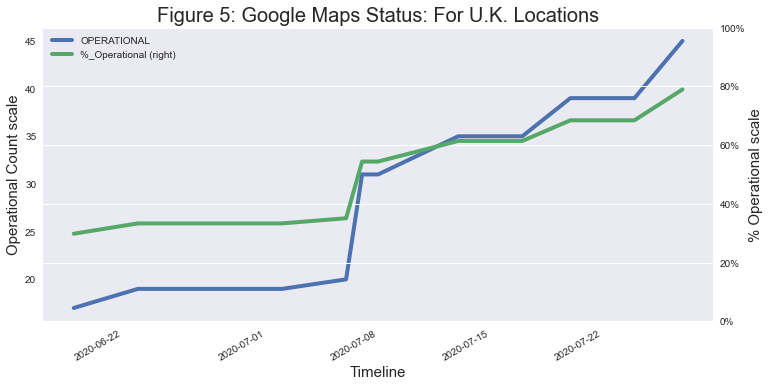

In [27]:
# CHART: Google Maps Status: For U.K. Locations
ax_1 = bfam_uk_timeline_counts[['OPERATIONAL','%_Operational']].plot(
    secondary_y='%_Operational',figsize=(12,6),linewidth=4);
ax_1.set_ylabel('Operational Count scale',fontsize=15)
ax_1.set_xlabel('Timeline',fontsize=15)
ax_1.right_ax.set_ylabel('% Operational scale',fontsize=15)
ax_1.right_ax.set_ylim(0,1)
vals_r = ax_1.right_ax.get_yticks()
ax_1.right_ax.set_yticklabels(['{:,.0%}'.format(y) for y in vals_r]);
plt.title("Figure 5: Google Maps Status: For U.K. Locations",fontsize=20);

## Total U.S.:
Below, I join the BFAM Website locations and the broader-search locations to extrapolate to the whole of the U.S. This strong sample represents \~600 locations of the total \~710 locations in the U.S. (\~85%).  

In [28]:
# Join BFAM Website locations and broader-search locations
total_us_timeline = clean_bfam_status_timeline.append(bfam_broad_search_status_timeline)

In [29]:
# Summary Statistics Table: Total U.S. Locations (~600/~700)
total_us_dates_list = list(total_us_timeline.columns)
_initialize_counts = total_us_timeline[total_us_dates_list[1]].value_counts()
total_us_timeline_counts = _initialize_counts.to_frame(name=total_us_timeline[total_us_dates_list[1]].name)
for i in range(2,len(total_us_dates_list)):
    total_us_timeline_counts = total_us_timeline_counts.join(total_us_timeline[total_us_dates_list[i]].value_counts(),how='outer')

# Add Total and % of Total Columns
total_us_timeline_counts = total_us_timeline_counts.T
total_us_timeline_counts['Total_Locations'] = total_us_timeline_counts.sum(axis=1)
total_us_timeline_counts['%_Operational'] = total_us_timeline_counts['OPERATIONAL'] / total_us_timeline_counts['Total_Locations']
total_us_timeline_counts['%_Temp_Closed'] = total_us_timeline_counts['CLOSED_TEMPORARILY'] / total_us_timeline_counts['Total_Locations']
total_us_timeline_counts['%_Perm_Closed'] = total_us_timeline_counts['CLOSED_PERMANENTLY'] / total_us_timeline_counts['Total_Locations']

# Convert dates and index to datetime for more functionality:
total_us_timeline_counts.index = pd.to_datetime(total_us_timeline_counts.index)
total_us_timeline_counts.index.name = 'Dates'

# Clean up the non-overlapping dates with drop_na (otherwise the data is confusing)
total_us_timeline_remove_na = total_us_timeline_counts.dropna(axis=0)

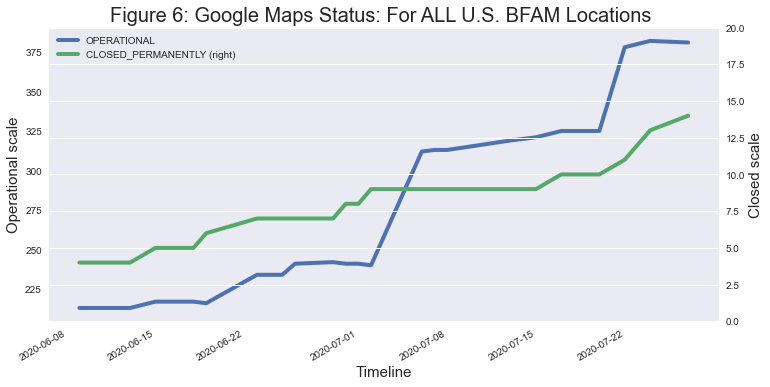

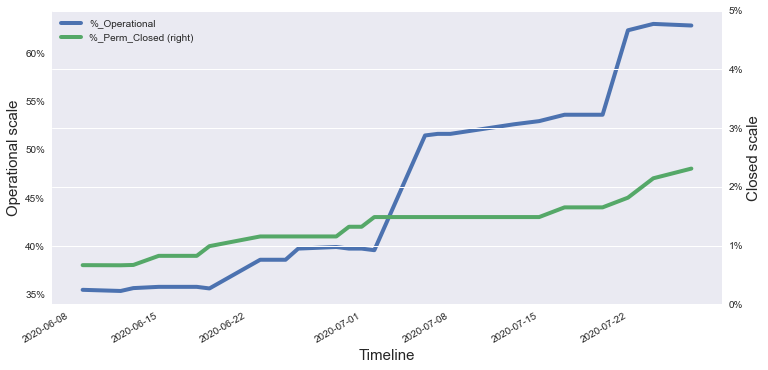

In [30]:
# CHART: Google Maps Status: For ALL U.S. BFAM Locations 
ax_6_1 = total_us_timeline_remove_na[['OPERATIONAL','CLOSED_PERMANENTLY']].plot(
    secondary_y='CLOSED_PERMANENTLY',figsize=(12,6),linewidth=4);
ax_6_1.set_ylabel('Operational scale',fontsize=15)
ax_6_1.set_xlabel('Timeline',fontsize=15)
ax_6_1.right_ax.set_ylabel('Closed scale',fontsize=15)
ax_6_1.right_ax.set_ylim(0,20)

plt.title("Figure 6: Google Maps Status: For ALL U.S. BFAM Locations ",fontsize=20)

ax_6_2 = total_us_timeline_remove_na[['%_Operational','%_Perm_Closed']].plot(
    secondary_y='%_Perm_Closed',figsize=(12,6),linewidth=4);
ax_6_2.set_ylabel('Operational scale',fontsize=15)
ax_6_2.set_xlabel('Timeline',fontsize=15)
ax_6_2.right_ax.set_ylabel('Closed scale',fontsize=15)
ax_6_2.right_ax.set_ylim(0,0.05);
vals_6_2 = ax_6_2.get_yticks();
ax_6_2.set_yticklabels(['{:,.0%}'.format(y) for y in vals_6_2])
vals_r = ax_6_2.right_ax.get_yticks()
ax_6_2.right_ax.set_yticklabels(['{:,.0%}'.format(y) for y in vals_r]);

## Pull in Analyst Estimates (Goldman Sachs Research)


In [31]:
# Goldman Sachs Research: Bright Horizons Family Solutions Estimates
# Load CSV: 
may_gs_ests_path = csv_folder / Path('GS_Ests_May.csv')
may_gs_ests = pd.read_csv(may_gs_ests_path,index_col=0,parse_dates=True)

june_gs_ests_path = csv_folder / Path('GS_Ests_June.csv')
june_gs_ests = pd.read_csv(june_gs_ests_path,index_col=0,parse_dates=True)
# Index.name = 'Period'; and is the start-date of the Quarter
# Column named 'Index' is the quarter_end month-year

In [32]:
# X-Axis: 
#THESE VALUES WILL ONLY MAKE SENSE FOR THE % CHANGE COLUMN, OTHERWISE THEY ARE (Q-avg vs. daily numbers)

#May:
may_q4_19 = may_gs_ests.loc['2019Q4'] # Q4'19 
may_q1_20 = may_gs_ests.loc['2020Q1'] # Q1'20 

# Daily Q2'20 (1 Apr - 31 Jun) through Q3'20 (1 Jul - 31 Sep)
may_q2_20 = may_gs_ests.loc['2020Q2':'2020Q3'].resample('B').ffill()  #This isn't ffilling Q3
may_q2_q3_20 = may_gs_ests.loc['2020Q2':'2020Q4'].resample('B').ffill()  
may_q2_q4_20 = may_gs_ests.loc['2020Q2':'2021Q1'].resample('B').ffill()  

may_q4_20 = may_gs_ests.loc['2020Q4'] # Q4'19  # Q4'20
may_a2021 = may_gs_ests.loc['2021Q1':'2021Q4'].resample('A').mean()  # 2021
may_a2022 = may_gs_ests.loc['2022Q1':'2022Q4'].resample('A').mean()  # 2022

#June:
june_q4_19 = june_gs_ests.loc['2019Q4'] # Q4'19 
june_q1_20 = june_gs_ests.loc['2020Q1'] # Q1'20 

# Daily Q2'20 (1 Apr - 31 Jun) through Q3'20 (1 Jul - 31 Sep)
june_q2_20 = june_gs_ests.loc['2020Q2':'2020Q3'].resample('B').ffill() #This isn't ffilling Q3
june_q2_q3_20 = june_gs_ests.loc['2020Q2':'2020Q4'].resample('B').ffill() 
june_q2_q4_20 = june_gs_ests.loc['2020Q2':'2021Q1'].resample('B').ffill() 

june_q4_20 = june_gs_ests.loc['2020Q4'] # Q4'19  # Q4'20
june_a2021 = june_gs_ests.loc['2021Q1':'2021Q4'].resample('A').mean()  # 2021
june_a2022 = june_gs_ests.loc['2022Q1':'2022Q4'].resample('A').mean()  # 2022

In [33]:
# Check that indexes are compatible to join: (merging on DatetimeIndex and PeriodIndex)
old_us_index_name = total_us_timeline_remove_na.index.name
if type(total_us_timeline_remove_na.index) != pd.DatetimeIndex:
    total_us_timeline_remove_na.index = total_us_timeline_remove_na.index.to_timestamp()
    total_us_timeline_remove_na.index.name = old_us_index_name
    print('If-statement was executed')
else:
    pass

In [34]:
# Q2
both_q2_gs_ests = may_q2_20.join(june_q2_20,on='Period',lsuffix='_may',rsuffix='_june')
search_and_gs = both_q2_gs_ests[['Center_%_Chg_GS_Est_May','Center_%_Chg_GS_Est_June']].join(
    total_us_timeline_remove_na, on='Period', how='left')

#Q2 - Q3
both_q2_q3_gs_ests = may_q2_q3_20.join(june_q2_q3_20,on='Period',lsuffix='_may',rsuffix='_june')
search_and_gs_q2_q3 = both_q2_q3_gs_ests[['Center_%_Chg_GS_Est_May','Center_%_Chg_GS_Est_June']].join(
    total_us_timeline_remove_na,on='Period', how='left')

#Q2 - Q4
both_q2_q4_gs_ests = may_q2_q4_20.join(june_q2_q4_20,on='Period',lsuffix='_may',rsuffix='_june')
search_and_gs_q2_q4 = both_q2_q4_gs_ests[['Center_%_Chg_GS_Est_May','Center_%_Chg_GS_Est_June']].join(
    total_us_timeline_remove_na, on='Period', how='left')

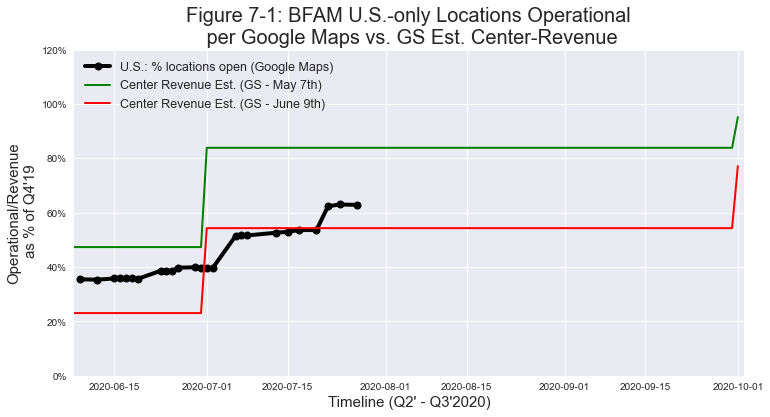

In [35]:
fig_7_1,ax_7_1 = plt.subplots(figsize=(12,6))
ax_7_1.plot(search_and_gs_q2_q3['%_Operational'].dropna(),
          'o-', color='black', markersize=8, linewidth=4)
ax_7_1.plot(search_and_gs_q2_q3['Center_%_Chg_GS_Est_May'],
            '-', color='green', linewidth=2)
ax_7_1.plot(search_and_gs_q2_q3['Center_%_Chg_GS_Est_June'],
            '-', color='red', linewidth=2)
ax_7_1.set(xlim=(total_us_timeline_remove_na.index[0] - pd.DateOffset(days=1), 
               search_and_gs_q2_q3.index[-1] + pd.DateOffset(days=1)), ylim=(0, 1.2)) 
ax_7_1.set_title('Figure 7-1: BFAM U.S.-only Locations Operational\n per Google Maps vs. GS Est. Center-Revenue', fontsize=20) 
ax_7_1.set_ylabel("Operational/Revenue\n as % of Q4'19", fontsize=15)
ax_7_1.set_xlabel("Timeline (Q2' - Q3'2020)", fontsize=15)

vals_7_1 = ax_7_1.get_yticks();
ax_7_1.set_yticklabels(['{:,.0%}'.format(y) for y in vals_7_1])

new_labels_dict = {'%_Operational': 'U.S.: % locations open (Google Maps)',
                   'Center_%_Chg_GS_Est_May': 'Center Revenue Est. (GS - May 7th)',
                   'Center_%_Chg_GS_Est_June': 'Center Revenue Est. (GS - June 9th)'}
ax_7_1.legend(labels=new_labels_dict.values() ,fontsize=12.5, loc="upper left");


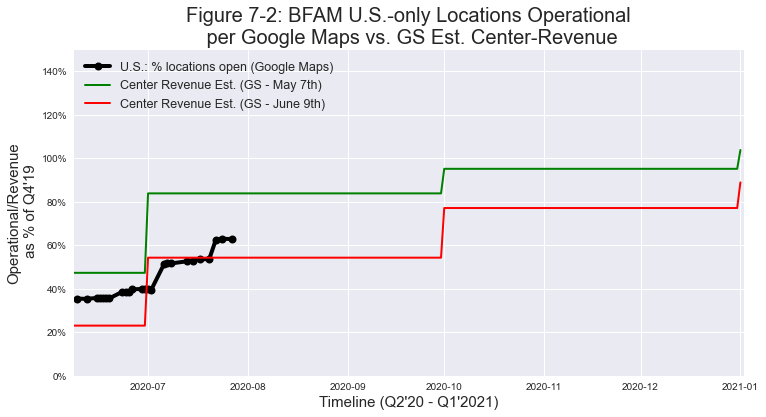

In [36]:
fig_7_2,ax_7_2 = plt.subplots(figsize=(12,6))
ax_7_2.plot(search_and_gs_q2_q4['%_Operational'].dropna(),
          'o-', color='black', markersize=8, linewidth=4,)
ax_7_2.plot(search_and_gs_q2_q4['Center_%_Chg_GS_Est_May'],
            '-', color='green', linewidth=2,)
ax_7_2.plot(search_and_gs_q2_q4['Center_%_Chg_GS_Est_June'],
            '-', color='red', linewidth=2,)
ax_7_2.set(xlim=(total_us_timeline_remove_na.index[0] - pd.DateOffset(days=1), 
               search_and_gs_q2_q4.index[-1] + pd.DateOffset(days=1)), ylim=(0, 1.5)) 
#plt.axhline(1-total_us_timeline_remove_na['%_Perm_Closed'][-1], color="blue", linestyle="--",alpha=0.85);
ax_7_2.set_title('Figure 7-2: BFAM U.S.-only Locations Operational\n per Google Maps vs. GS Est. Center-Revenue', fontsize=20) 
ax_7_2.set_ylabel("Operational/Revenue\n as % of Q4'19", fontsize=15)
ax_7_2.set_xlabel("Timeline (Q2'20 - Q1'2021)", fontsize=15)

vals_7_2 = ax_7_2.get_yticks();
ax_7_2.set_yticklabels(['{:,.0%}'.format(y) for y in vals_7_2])

new_labels_dict = {'%_Operational': 'U.S.: % locations open (Google Maps)',
                   'Center_%_Chg_GS_Est_May': 'Center Revenue Est. (GS - May 7th)',
                   'Center_%_Chg_GS_Est_June': 'Center Revenue Est. (GS - June 9th)',
                  'Horizontal Line': "100% minus % permanently closed"}
ax_7_2.legend(labels=new_labels_dict.values() ,fontsize=12.5, loc="upper left");


### U.K. Data:

In [37]:
#Q2 - Q4
both_q2_q4_gs_ests = may_q2_q4_20.join(june_q2_q4_20,on='Period',lsuffix='_may',rsuffix='_june')
uk_and_gs_q2_q4 = both_q2_q4_gs_ests[['Center_%_Chg_GS_Est_May','Center_%_Chg_GS_Est_June']].join(
    bfam_uk_timeline_counts.asfreq('B'),on='Period', how='left')
#Otherwise this creates a new index using total_us_timeline_remove_na

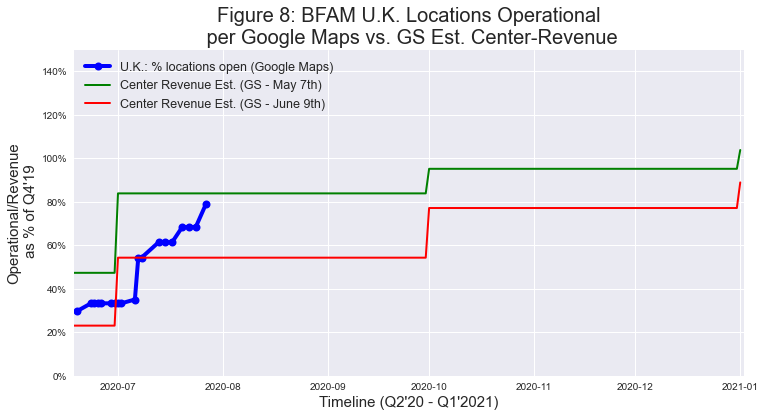

In [38]:
fig_8,ax_8 = plt.subplots(figsize=(12,6))
ax_8.plot(uk_and_gs_q2_q4['%_Operational'].dropna(),
          'o-', color='blue', markersize=8, linewidth=4,)
ax_8.plot(uk_and_gs_q2_q4['Center_%_Chg_GS_Est_May'],'-', color='green', linewidth=2,)
ax_8.plot(uk_and_gs_q2_q4['Center_%_Chg_GS_Est_June'],'-', color='red', linewidth=2,)
ax_8.set(xlim=(bfam_uk_timeline_counts.index[0] - pd.DateOffset(days=1), 
               uk_and_gs_q2_q4.index[-1] + pd.DateOffset(days=1)), ylim=(0, 1.5)) 
#plt.axhline(1- UK  timeline ['%_Perm_Closed'][-1], color="blue", linestyle="--",alpha=0.85);
ax_8.set_title('Figure 8: BFAM U.K. Locations Operational\n per Google Maps vs. GS Est. Center-Revenue', fontsize=20) 
ax_8.set_ylabel("Operational/Revenue\n as % of Q4'19", fontsize=15)
ax_8.set_xlabel("Timeline (Q2'20 - Q1'2021)", fontsize=15)

vals_8 = ax_8.get_yticks();
ax_8.set_yticklabels(['{:,.0%}'.format(y) for y in vals_8])

new_labels_dict = {'%_Operational': 'U.K.: % locations open (Google Maps)',
                   'Center_%_Chg_GS_Est_May': 'Center Revenue Est. (GS - May 7th)',
                   'Center_%_Chg_GS_Est_June': 'Center Revenue Est. (GS - June 9th)',
                  'Horizontal Line': "100% minus % permanently closed"}
ax_8.legend(labels=new_labels_dict.values() ,fontsize=12.5, loc="upper left");


# Conclusion:

### Reviewing Conclusions from the above Data & Analysis:

<b>BFAM has less than ~40% of it's U.S. locations open at the end-Q2'20, with a much smaller fraction of ~25% for the leased-locations where BFAM bears more of the overhead, financial burden, and risk.</b>

As of the end of June 2020, coinciding with the end of Q2'2020, only \~25% of the \~440 locations listed on BFAM's website were identified as operational on Google Maps. Note that these locations are more likely to be the locations wherein BFAM pays leases and bears all of the financial burden. Recall that BFAM operates two distinct business models in their daycare center vertical (>80% of total company revenue). One is the lease-based business and the other is an employer-sponsored model, wherein an employer will cover some or all of the overhead costs and pays BFAM a management fee to operate the daycare center for it's employees. An additional, \~75% of the 165 locations which are not listed on BFAM's website, but were identified by a broader Google Maps search, were operational. Again, these locations are more likely to be employer sponsored locations. <b>Overall, this sample of \~600 U.S. locations, out of a total of ~700 U.S. locations, had less than 40% locations open as of the end-Q2'20.</b> 

<b>Results in the U.K. appear similar with \~1/3rd of BFAM's U.K. locations (representing \~35% of total global locations) operational at end-Q2'20;</b> albeit with a much smaller sample size at \~18% (57 locations/313 total U.K. locations) vs. the U.S. data at \~85% sample size (\~600 locations/710 total U.S. locations).

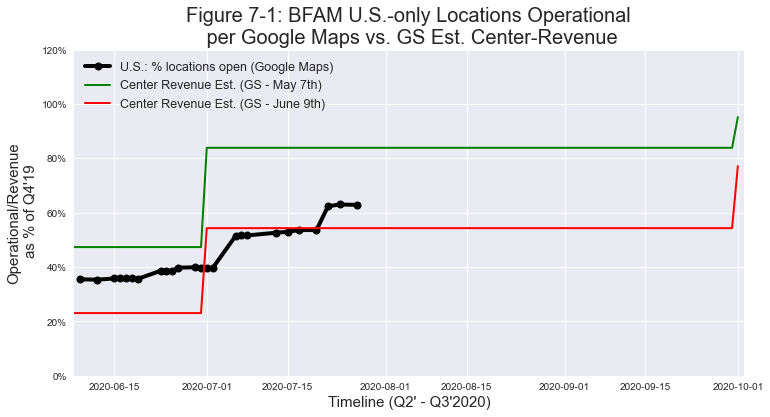

In [39]:
fig_7_1

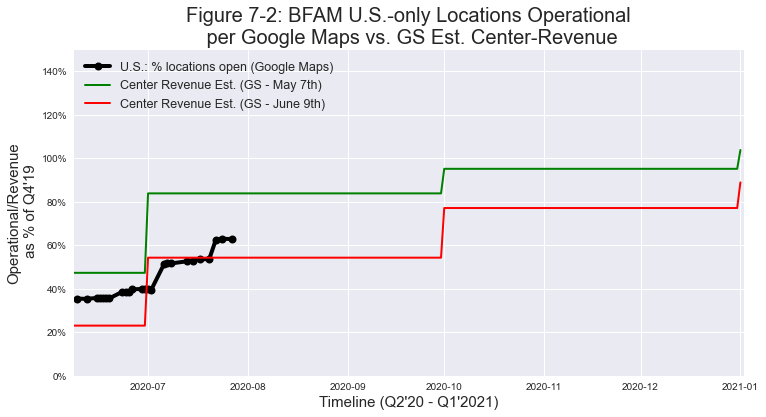

In [40]:
fig_7_2

To bridge the gap between the current operational status and investor expectations potentially embedded in BFAM's share price, I pull in Goldman Sachs Research analyst's revenue estimates for the remainder of this year. 

It's worth noting that the metric of "the % of locations that are open/operational" is not totally analogous to the "% of Q4'19 revenue" metric with which I am comparing it to. An open location today is very likely to be operating at a "same-store" utilization rate below the level it operated at pre-COVID, making this statistic a ceiling on potential revenue. The Green line above plots revenue estimates for the center-based business (>80% of revenue) published by GS on May 7th, and the Red line plots the revenue estimate published by GS on June 9th. It's worthwhile to note that the analyst <u>lowered</u> their 2020 EPS estimate by \~30% to 2.73 from 3.73 for 2020 (green-line to red-line), but still <u>raised</u> their target price by using a higher, 56.0x forward P/E multiple, equating to nearly 3x the NTM P/E multiple on the S&P 500 at the time. 

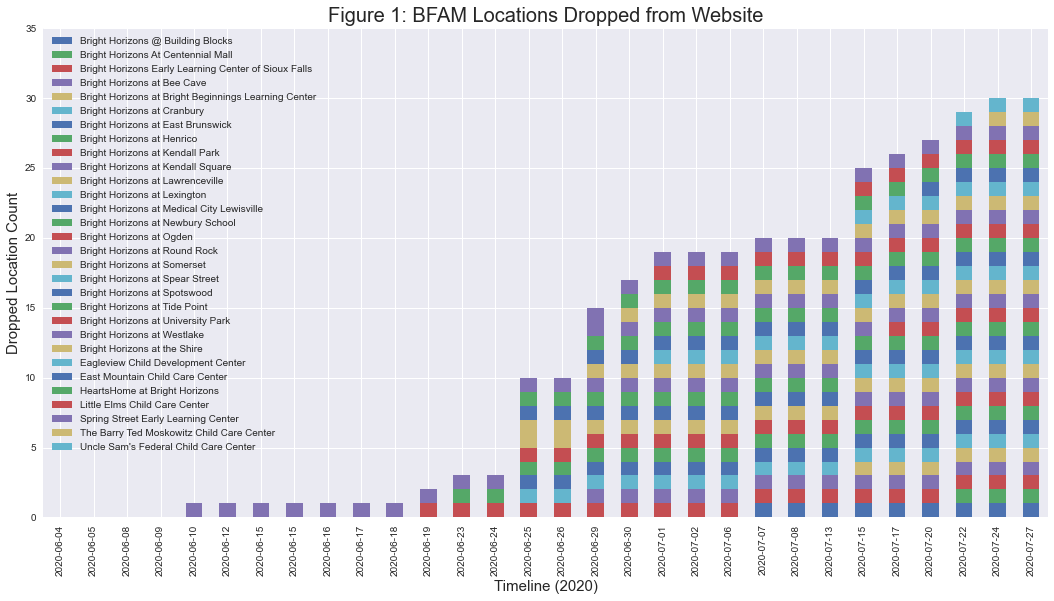

In [41]:
# Figure 1: Locations Dropped from BFAM Website
y_max_fig_1 = (round(final_dropped.index.size/5)+1)*5 # Y-Lim

final_dropped.plot(kind='bar', stacked=True, figsize=(18,9), ylim=[0, y_max_fig_1]) # include_bool=True, figsize=plt.figaspect(0.75)
plt.title("Figure 1: BFAM Locations Dropped from Website",fontsize=20) 
plt.ylabel("Dropped Location Count",fontsize=15)
plt.xlabel("Timeline (2020)",fontsize=15)
plt.legend(fontsize=10,loc="upper left"); #,ncol=2)

<b>Importantly, to date, the pace at which BFAM is opening locations back up has not significantly exceeding the pace at which it is permanently closing them.</b>

A relevant metric besides the current fraction of the daycare center network that is operational, is the pace at which BFAM has been bringing "temporarily closed" locations back to "operational" compared to the pace at which locations are being "permanently closed." Figure 1 above shows a timeline of the number of locations that have been dropped from the "Location" page of BFAM's website - identified by a daily webscrape. So far the changes to the website seem to be outpacing the update to the business status on Google Maps. In other words, these locations are still being displayed as a mix of "temporarily closed" or "permanently closed" on Google Maps. As of July 1st, of the locations that have been dropped from BFAM's website, there have been three shown as "permanently closed" on Google Maps: the BFAM of Sioux Falls, BFAM at Bee Cave, and Spring Street Early Learning Center. Also see Figure 3 above for permanently closed locations from the U.S. locations that were not listed on the BFAM website. 

As a theoretical benchmark, a ratio of the cumulative count of locations that moved to operational vs. permanently closed of \~2:1 would bring utilization up to a peak of ~80% of the pre-COVID level. Recall "utilization" is really the % of locations that are open, which is ~40% currently. Thus a 2:1 ratio would have 40% more open with a commensurate 20% of locations being closed-permanently. An outcome worse than this seems almost certainly bad, and not factored into analyst's estimates, and an outcome better than this may possibly propel the shares higher. For reference, GS Ests. have BFAM's daycare center revenue averaging ~88% of the Q4'19 level (annualized) in 2021 and ~103% in 2022. 

<b>In the chart below, you can see that cumulatively, through Q2'20 and into Q3'20, BFAM seems to be permanently closing locations at a pace that is less than the pace at which it is brining locations back to operational, but not by much.</b> I am particularly interested in how this ratio trends over time.

In [42]:
# Ratio of Locations becoming\n Operational vs. Permanently Closing
# Permanently Closed:
website_dropped = final_dropped
website_dropped['Total'] = website_dropped.sum(axis=1)
website_dropped.index.name = 'Dates'
website_dropped.index = website_dropped.index.to_timestamp()
closed_website = website_dropped['Total'].diff()
closed_broad = bfam_broad_search_timeline_counts['CLOSED_PERMANENTLY'].diff()
closed_sum = pd.concat([closed_website.fillna(value=int(0)),closed_broad.fillna(value=int(0))]).groupby('Dates').sum()

# Operational:
operational_website = bfam_timeline_counts['OPERATIONAL'].diff()
operational_broad = bfam_broad_search_timeline_counts['OPERATIONAL'].diff()
operational_uk = bfam_uk_timeline_counts['OPERATIONAL'].diff()
operational_sum = pd.concat([operational_website.fillna(value=int(0)),operational_broad.fillna(value=int(0)),
                       operational_uk.fillna(value=int(0))]).groupby('Dates').sum()

# Final Output: 
open_close_ratio = pd.merge(operational_sum.cumsum().rename('Operational'), closed_sum.cumsum().rename('Closed'),
                            how='inner',left_on='Dates',right_on='Dates')
open_close_ratio['Open vs. Closed Ratio'] = open_close_ratio['Operational'] / open_close_ratio['Closed']
#open_close_ratio

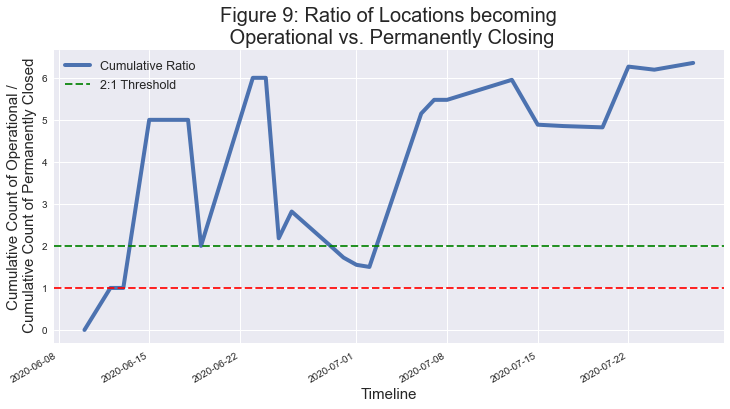

In [43]:
# Figure 9: Ratio of Locations becoming Operational vs. Permanently Closing
fig_9,ax = plt.subplots(figsize=(12,6));
plt.plot(open_close_ratio['Open vs. Closed Ratio'], linewidth=4)
plt.axhline(2, color="green", linestyle="--", linewidth=2, alpha=0.85);
plt.axhline(1, color="red", linestyle="--", linewidth=2, alpha=0.85);


ax.set_title('Figure 9: Ratio of Locations becoming\n Operational vs. Permanently Closing', fontsize=20) 
ax.set_ylabel("Cumulative Count of Operational /\n Cumulative Count of Permanently Closed", fontsize=15)
ax.set_xlabel("Timeline", fontsize=15)

fig_9.autofmt_xdate()

new_labels_dict = {'Ratio': 'Cumulative Ratio',
                  'Horizontal Line': "2:1 Threshold"}
ax.legend(labels=new_labels_dict.values() ,fontsize=12.5, loc="upper left");


## Investment Conclusions:
An investor can either be optimistic about the pace that BFAM will re-opening its locations, the prospects for the business and the trajectory of the share price; or an investor can be pessimistic. What's nice about this tool, and the data it provides, is that it gives a real-time look into the pace of the re-opening and downsizing, before financial results are announced to the market. This is via a very robust data source from Google Maps and the company's own website, giving confidence to any conclusions that are made based on the information.  

My investment view is that BFAM shares were overvalued in the pre-COVID era, with the below-average quality attributes of its business (competitive edge, barriers to entry, operating leverage) and the weaker secular forces driving its growth, being overvalued in the market. As we stand today, that business is operating at less than half of its capacity, and generating little or no earnings, if not losses. And there are a very broad range of future outcomes - from potentially fully-reopening, to potentially operating at a low utilization rate for a sustained period of time and being forced to significantly curtail the size of the daycare fleet. Meanwhile, expectations embedded in the share price seem to be optimistic - looking at GS Estimates and BFAM trading at ~75% of it's year-ago level. I view the risks to be mispriced. 

Further, this analysis captures the pace at which Bright Horizons is permanently closing locations, which I view as the biggest informational advantage provided by this analysis. Not only has there been little to no discussion in the market regarding permanent closures – whether in BFAM guidance, press releases, 8-K filings, the Q1’20 earnings call, or in GS Equity Research. But, the pace at which temporarily closed locations have become permanently closed, relative to the pace at which they have been re-opened, is particularly alarming – especially since analyst estimates and the stock seem to indicate a robust recovery is expected by the market.

The updates to this data will help validate or disprove my investment thesis.

#### Q2'20 Mgmt. Guidance Tracker:
In an 8-K published <u>June 8th 2020</u>, BFAM stated it "expects to reopen between 150 and 175 centers by June 30, 2020" and "expect to continue the phased reopening through the third quarter." From the Google Map data, BFAM was operating at ~35% on June 8th. Reopening between 150 and 175 centers, if strictly in the U.S., implies that the U.S. "utilization rate" will increase to 57% by the end of June and trend higher through July. This will all take place before BFAM reports Q2'20 results - likely early-August.

In [44]:
guidance_string =  """
Q2'20 Guidance Tracker: (mgmt. guidance issued June 8th)

Opening ~163 centers (150-175 guidance) implies an increase in utilization of the U.S. network by ~23%, 
if all locations are in the U.S. only, and an increase in global utilization by ~14%, across both the U.S. and U.K. 

Since {}, U.S.-only utilization has increased by ~{}%, from {}% to {}% (as of {}). 
Since {}, U.K.-only utilization has increased by ~{}%, from {}% to {}% (as of {}). 
 
""".format(total_us_timeline_remove_na.index[0].strftime("%m/%d"), 
          int(100*(total_us_timeline_remove_na['%_Operational'][-1] - total_us_timeline_remove_na['%_Operational'][0])),
           int(100*total_us_timeline_remove_na['%_Operational'][0]),
           int(100*total_us_timeline_remove_na['%_Operational'][-1]),
           total_us_timeline_remove_na.index[-1].strftime("%m/%d"),
           
           bfam_uk_timeline_counts.index[0].strftime("%m/%d"), 
          int(100*(bfam_uk_timeline_counts['%_Operational'][-1] - bfam_uk_timeline_counts['%_Operational'][0])),
           int(100*bfam_uk_timeline_counts['%_Operational'][0]),
           int(100*bfam_uk_timeline_counts['%_Operational'][-1]),
           bfam_uk_timeline_counts.index[-1].strftime("%m/%d"))
            
print(guidance_string)


Q2'20 Guidance Tracker: (mgmt. guidance issued June 8th)

Opening ~163 centers (150-175 guidance) implies an increase in utilization of the U.S. network by ~23%, 
if all locations are in the U.S. only, and an increase in global utilization by ~14%, across both the U.S. and U.K. 

Since 06/09, U.S.-only utilization has increased by ~27%, from 35% to 62% (as of 07/27). 
Since 06/19, U.K.-only utilization has increased by ~49%, from 29% to 78% (as of 07/27). 
 



### Avenues of Further Analysis:

LinkedIn Data:

The above analysis mainly concerns top-line forecasts: the fleet of day-care center and the ability to generate prior revenue. The other important feature of a valuation and investment thesis is the level of operating expenses - how much lease payments continue to be paid and how much employee expenses continue to be paid. A high level of employee retention would provide evidence that the future location count will remain robust, but provide a major drag on near-term earnings. Meanwhile, low employee retention would support near-term earnings estimates but call into question the long-term recovery in revenues and earnings. LinkedIn could potentially provide valuable insights into the level and pace of employee cutbacks, giving more clarity to the overall financial picture for BFAM (opex and revenue). 

Credit Card Data:

Existing Bright Horizons customers are billed in the beginning of the month for the child-care services rendered for the month ahead. From what I understand of Credit Card data, it could be useful to provide an outlook on the level of revenue per center that becomes operational. Within the data, customers of Bright Horizons could be identified. Keeping track of when payments stopped, when the restarted, and combining that with insights about the locations in the same city, and when they became operational, can yield insights into the pace of single-center revenue coming back to pre-Covid levels - true utilization figures and better revenue estimates. The level of customer retention would be a important input to revenue forecasts.